# Observable Plotting Notebook

This notebook demonstrates how the auxiliary plotting functions work. These functions require only a full cosmology dictionary of the type described in `likelihood.cosmo.cosmology` to function.

## Set-up

First, we import the required modules, and set-up a mock cosmology dictionary, using existing external benchmark files, and, where necessary `CAMB`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb

from astropy import constants as const
from scipy import interpolate
from likelihood.auxiliary.plotter import Plotter
from likelihood.cosmo.cosmology import Cosmology


First, we load the matter power spectrum used to generate the Weak Lensing benchmark. Here, a dummy class is created to make sure the matter power spectrum interpolator has the same format as a `CAMB` power spectrum interpolator. <span style="color:red"> **Note:** </span> As the the provided power spectrum file only covers z up to 2.5. The code requires the power spectrum to be evaluated up to z=4. Accordingly, `CAMB` is used to create the matter power spectrum used in this notebook, below. However, we leave this in to demonstrate how an external power spectrum could be used.


In [3]:
P_file = np.loadtxt('./data/ExternalBenchmark/Photometric/Pnl-TB-LCDM.dat')
ks = 10**P_file[:, 0]
zs = P_file[:, 1]
P_lin = 10**P_file[:, 3]
zk = np.concatenate((zs.reshape(-1,1),ks.reshape(-1,1)), axis=1)
P_interp = interpolate.LinearNDInterpolator(zk, P_lin)


class mock_P_obj:
    def __init__(self, p_interp):
        self.P = p_interp


test_P = mock_P_obj(P_interp)

Similarly, the comoving distance and Hubble function are loaded, and the angular diameter distance is calculated assuming flatness.

In [4]:
cmov_file = np.loadtxt('./data/ExternalBenchmark/Photometric/ComDist-LCDM-Lin-noIA.dat')
zs_r = cmov_file[:, 0]
rs = cmov_file[:, 1]
ang_dists = rs/(1.0 + zs_r)

rz_interp = interpolate.InterpolatedUnivariateSpline(x=zs_r, y=rs, ext=0)
dz_interp = interpolate.InterpolatedUnivariateSpline(x=zs_r, y=ang_dists, ext=0)


In [5]:
Hz_file = np.loadtxt('./data/ExternalBenchmark/Photometric/Hz.dat')
zs_H = Hz_file[:, 0]
Hs = Hz_file[:, 1]

Hs_mpc = Hz_file[:, 1] / const.c.to('km/s').value

Hz_interp = interpolate.InterpolatedUnivariateSpline(x=zs_H, y=Hs,
                                                     ext=0)

Hmpc_interp = interpolate.InterpolatedUnivariateSpline(x=zs_H,
                                                       y=Hs_mpc,
                                                       ext=0)

A modified gravity sigma function that is always 1 is created.

In [6]:
MG_vals = np.ones_like(ks)
MG_interp = interpolate.LinearNDInterpolator(zk, MG_vals, fill_value=1.0)


We then create a mock cosmology dictionary, following the structure in `likelihood.cosmo.cosmology`, and fill it with quantities that are already known.

In [7]:
mock_cosmo_dic = {
                'H0': 67.0,
                'omch2': 0.121203,
                'ombh2': 0.022445,
                'ns': 0.96,
                'sigma_8_0': 0.816,
                'As': 2.115e-9,
                'w': -1.0,
                'omkh2': 0.0,
                'omnuh2': 0.0,
                'c': const.c.to('km/s').value,
                'r_z_func': rz_interp,
                'd_z_func': dz_interp,
                'H_z_func': Hz_interp,
                'H_z_func_Mpc': Hmpc_interp,
                'z_win': np.linspace(0.0, 4.0, 100),
                'k_win': np.linspace(0.001, 10.0, 100),
                'MG_sigma': MG_interp}

mock_cosmo_dic['H0_Mpc'] = \
    mock_cosmo_dic['H0'] / const.c.to('km/s').value
mock_cosmo_dic['Omb'] = \
    mock_cosmo_dic['ombh2'] / (mock_cosmo_dic['H0'] / 100.)**2.
mock_cosmo_dic['Omc'] = \
    mock_cosmo_dic['omch2'] / (mock_cosmo_dic['H0'] / 100.)**2.
mock_cosmo_dic['Omnu'] = \
    mock_cosmo_dic['omnuh2'] / (mock_cosmo_dic['H0'] / 100.)**2.
mock_cosmo_dic['Omm'] = (mock_cosmo_dic['Omnu'] +
                         mock_cosmo_dic['Omc'] +
                         mock_cosmo_dic['Omb'])

We then use `CAMB` to calculate the missing quantities; in particular, sigma_8 and fsigma_8. These are also added to the dictionary.

In [8]:
cp = camb.set_params(ns=mock_cosmo_dic['ns'], H0=mock_cosmo_dic['H0'],
                             ombh2=mock_cosmo_dic['ombh2'],
                             omch2=mock_cosmo_dic['omch2'], w=-1.0,
                             omk=0.0,
                             wa=0.0, lmax=5000, WantTransfer=True,
                             dark_energy_model='DarkEnergyPPF', mnu=0.06,
                             As=mock_cosmo_dic['As'], TCMB=2.726, YHe=0.25, kmax=100.0,
                             redshifts=np.linspace(0.0, 5.0, 50).tolist())
results = camb.get_results(cp)
power = results.get_matter_power_interpolator(nonlinear=False, hubble_units=False, k_hunit=False)
sig_8_arr = results.get_sigma8()
sig_8_interp = interpolate.InterpolatedUnivariateSpline(x=np.linspace(0.0, 5.0, 50), y=sig_8_arr[::-1], ext=0)
f_sig_8_arr = results.get_fsigma8()
f_sig_8_interp = interpolate.InterpolatedUnivariateSpline(x=np.linspace(0.0, 5.0, 50), y=f_sig_8_arr[::-1], ext=0)
mock_cosmo_dic['Pk_interpolator'] = power
mock_cosmo_dic['Pk_delta'] = power
mock_cosmo_dic['sigma8_z_func'] = sig_8_interp
mock_cosmo_dic['fsigma8_z_func'] = f_sig_8_interp


Note: redshifts have been re-sorted (earliest first)


In order to enable plotting of both Galaxy Clustering probes, we need the various galaxy power spectra. These are calculated with the mock cosmology dictionary, together with the existing functions within the `cosmology` module.

In [9]:
cos_ins = Cosmology()
cos_ins.cosmo_dic.update(mock_cosmo_dic)
mock_cosmo_dic['Pgg_spec'] = cos_ins.Pgg_spec_def
mock_cosmo_dic['Pgdelta_spec'] = cos_ins.Pgd_spec_def
mock_cosmo_dic['Pgg_phot'] = cos_ins.Pgg_phot_def
mock_cosmo_dic['Pgdelta_phot'] = cos_ins.Pgd_phot_def
mock_cosmo_dic['Pgi_phot'] = cos_ins.Pgi_phot_def
mock_cosmo_dic['Pii'] = cos_ins.Pii_def
mock_cosmo_dic['Pdeltai'] = cos_ins.Pdeltai_def


We can now save various quantites that may be useful later, if we would like to run only the photometric or spectroscopic modules of the code without calculating cosmological quantities.

In [11]:
np.save('./f_sig_8_arr.npy', f_sig_8_arr)
np.save('./sig_8_arr.npy', sig_8_arr)

z_min = 0.0
z_max = 4.0
z_samp = 100
zs_base = np.linspace(z_min, z_max, z_samp)

k_samp_GC = 100
k_min_GC_phot_interp = 0.001
k_max_GC_phot_interp = 10.0
ks_base = np.logspace(np.log10(k_min_GC_phot_interp),
                         np.log10(k_max_GC_phot_interp),
                         k_samp_GC)
pdeltadelta_phot = np.array([power.P(zz, ks_base) for zz in zs_base])
pgg_phot = np.array([cos_ins.Pgg_phot_def(zz, ks_base) for zz in zs_base])
pgdelta_phot = np.array([cos_ins.Pgd_phot_def(zz, ks_base)
                         for zz in zs_base])
pii = np.array([cos_ins.Pii_def(zz, ks_base) for zz in zs_base])
pdeltai = np.array([cos_ins.Pdeltai_def(zz, ks_base) for zz in zs_base])
pgi_phot = np.array([cos_ins.Pgi_phot_def(zz, ks_base) for zz in zs_base])
pgi_spec = np.array([cos_ins.Pgi_spec_def(zz, ks_base) for zz in zs_base])

np.save('./pdd.npy', pdeltadelta_phot)
np.save('./pgg.npy', pgg_phot)
np.save('./pgd.npy', pgdelta_phot)
np.save('./pii.npy', pii)
np.save('./pdi.npy', pdeltai)
np.save('./pgi_phot.npy', pgi_phot)
np.save('./pgi_spec.npy', pgi_spec)

## Using the plotting routines

Now, we can straightforwardly use the auxiliary plotting routines. To use these, we first create `matplotlib.pyplot` axis objects, and then pass these to the relevant plotting functions, together with out specified cosmology dictionary. The functions can also allow the specification of `matplotlib` colours and linestyles using the `pl_colour` and `pl_linestyle` parameters. Custom labels for each individual plot can be specified with `pl_label`. Please see the function API for more details.

This allows greater flexibility to the user in how they want to plot the various combinations of observables. Accordingly, any axis scaling/labelling must be done after the functions are called. 

An example for each observable is given below. Also shown is how to plot the external benchmark/OULE3 values together with the error bars from the covariance matrix.

### Weak Lensing

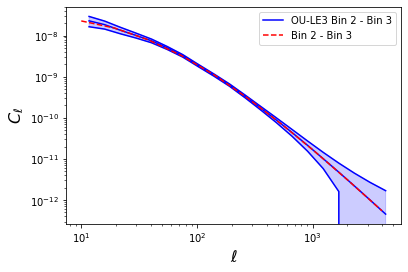

In [47]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

pl_inst = Plotter(cosmo_dic=mock_cosmo_dic)

ax1 = pl_inst.plot_external_Cl_phot(2, 3, ax1, probe='WL')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 2, 3, ax1, probe='WL', pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=16)
ax1.set_ylabel(r'$C_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()


### Photometric Galaxy Clustering

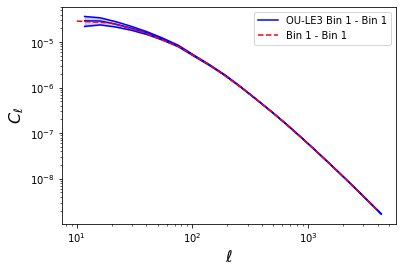

In [48]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='GC-Phot')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='GC-Phot', pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=16)
ax1.set_ylabel(r'$C_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()


### Weak Lensing x Photometric Galaxy Clustering Cross-spectra

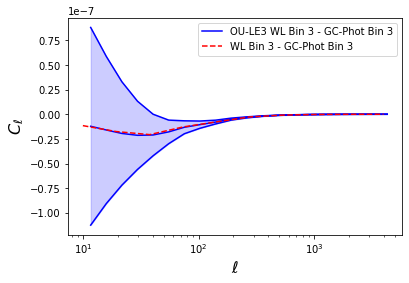

In [37]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_Cl_XC(3, 3, ax1)
ax1 = pl_inst.plot_Cl_XC(np.logspace(1, 3.6, 10), 3, 3, ax1, pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$\ell$', fontsize=16)
ax1.set_ylabel(r'$C_\ell$', fontsize=16)
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend()


### Spectroscopic Galaxy Clustering

Note: The internal and external spectra are currently plotted seperately due to the fact that the external spectra are supplied in different units. Once this is corrected, this notebook should be editted to place both on the same plot.

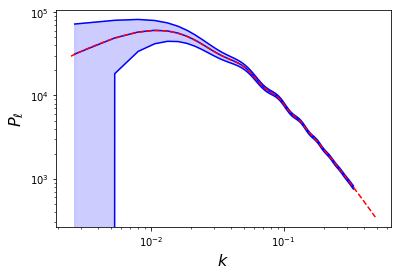

In [19]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)

ax1 = pl_inst.plot_external_GC_spec("1.2", 2, ax1, pl_label='a')
ax1 = pl_inst.plot_GC_spec_multipole(1.2, np.logspace(-2.6, -0.31), 2, ax1, pl_colour='r', pl_linestyle='--')
ax1.set_xlabel(r'$k$', fontsize=16)
ax1.set_ylabel(r'$P_\ell$', fontsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
